<a href="https://colab.research.google.com/github/iamstarstuff/MScDataScienceThesis/blob/main/ML%20Models%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn-intelex
!pip install sklearn-genetic-opt[all]

In [1]:
import sklearnex
sklearnex.patch_sklearn()

# # Getting the GPU info
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

# import tensorflow as tf
# # Making sure the GPU is connected and will be used
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# gpus

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# ALL IMPORTS
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


2023-07-22 01:02:49.162557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Choose one of the ways to import data below.

# My local path
df = pd.read_csv('/Users/pratik/Github/MScDataScienceThesis/Skyserver_SQL5_24_2023 12_41_33 PM.csv')

# Global Path
# df = pd.read_csv("https://raw.githubusercontent.com/iamstarstuff/MScDataScienceThesis/main/Skyserver_SQL5_24_2023%2012_41_33%20PM.csv")

In [4]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237660e+18,213.992460,-2.453992,17.92948,18.19919,18.66623,19.01955,19.31679,2379,301,3,32,4.543040e+18,STAR,0.000076,4035,55383,112
1,1.237660e+18,214.058474,-2.597317,18.79543,17.72650,17.31048,17.14916,17.10742,2379,301,3,32,1.031330e+18,STAR,0.000092,916,52378,30
2,1.237660e+18,214.551367,-2.504556,19.32994,18.36031,18.04727,17.91241,17.85185,2379,301,3,36,4.539760e+18,STAR,0.000496,4032,55333,463
3,1.237660e+18,215.094035,-2.431390,19.58494,19.71145,19.29750,19.19037,19.28850,2379,301,3,39,1.032490e+18,QSO,1.340945,917,52400,160
4,1.237660e+18,215.137407,-2.539874,19.12029,18.20783,17.91957,17.80769,17.77281,2379,301,3,40,1.032490e+18,STAR,-0.000352,917,52400,142


In [5]:
df.shape

(500000, 18)

In [6]:
df['class'].value_counts()

class
GALAXY    252355
STAR      193188
QSO        54457
Name: count, dtype: int64

In [7]:
df_new = pd.DataFrame()
for class_name, class_group in df.groupby('class'):
    df_new = pd.concat([df_new, class_group.head(10000)])

In [8]:
df = df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
highcorr = df[['u','g','r','i','z','redshift']].corr()

<Axes: >

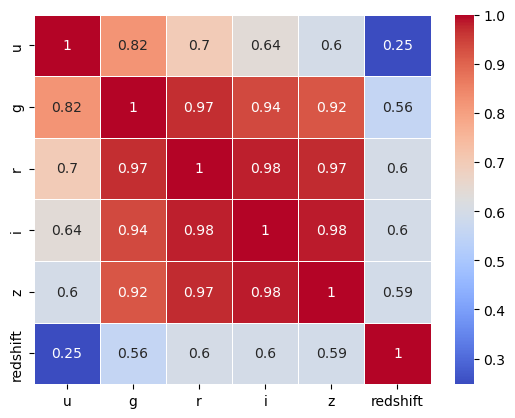

In [10]:
sns.heatmap(highcorr, annot=True, cmap='coolwarm',lw=0.5)

In [11]:
df_reduced = df[['u','g','r','i','z','redshift','class']]
df_reduced

,u,g,r,i,z,redshift,class
0,18.77424,17.22705,16.33456,15.93312,15.61520,0.117806,GALAXY
1,17.11961,17.23760,16.88869,16.87444,16.92442,-0.000950,STAR
2,18.12530,17.17554,16.80513,16.65383,16.59586,-0.000592,STAR
3,17.61290,15.67390,14.94450,14.67856,14.56172,-0.000006,STAR
4,18.86795,17.59894,17.09125,16.78167,16.57525,0.053254,GALAXY
...,...,...,...,...,...,...,...
29995,16.70061,15.28040,14.80139,14.63476,14.58381,-0.000058,STAR
29996,19.43687,17.83537,16.93449,16.45985,16.04228,0.114808,GALAXY
29997,17.35601,15.61297,14.80884,14.39444,14.08210,0.041596,GALAXY
29998,19.31746,19.21262,19.08568,18.98351,18.70999,2.055598,QSO


In [12]:
# Reshape the 'class' column to a 2D array
class_column_reshaped = df_reduced['class'].values.reshape(-1, 1)

# Initialize the encoder
label_encoder = LabelEncoder()

df_reduced['class_encoded'] = label_encoder.fit_transform(df_reduced['class'])

df_encoded = df_reduced

/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_8729/1027055509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['class_encoded'] = label_encoder.fit_transform(df_reduced['class'])


In [13]:
df_encoded

,u,g,r,i,z,redshift,class,class_encoded
0,18.77424,17.22705,16.33456,15.93312,15.61520,0.117806,GALAXY,0
1,17.11961,17.23760,16.88869,16.87444,16.92442,-0.000950,STAR,2
2,18.12530,17.17554,16.80513,16.65383,16.59586,-0.000592,STAR,2
3,17.61290,15.67390,14.94450,14.67856,14.56172,-0.000006,STAR,2
4,18.86795,17.59894,17.09125,16.78167,16.57525,0.053254,GALAXY,0
...,...,...,...,...,...,...,...,...
29995,16.70061,15.28040,14.80139,14.63476,14.58381,-0.000058,STAR,2
29996,19.43687,17.83537,16.93449,16.45985,16.04228,0.114808,GALAXY,0
29997,17.35601,15.61297,14.80884,14.39444,14.08210,0.041596,GALAXY,0
29998,19.31746,19.21262,19.08568,18.98351,18.70999,2.055598,QSO,1


In [14]:
X = df_encoded[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = df_encoded[['class_encoded']]

In [36]:
y = y.values.ravel()

In [15]:
X

,u,g,r,i,z,redshift
0,18.77424,17.22705,16.33456,15.93312,15.61520,0.117806
1,17.11961,17.23760,16.88869,16.87444,16.92442,-0.000950
2,18.12530,17.17554,16.80513,16.65383,16.59586,-0.000592
3,17.61290,15.67390,14.94450,14.67856,14.56172,-0.000006
4,18.86795,17.59894,17.09125,16.78167,16.57525,0.053254
...,...,...,...,...,...,...
29995,16.70061,15.28040,14.80139,14.63476,14.58381,-0.000058
29996,19.43687,17.83537,16.93449,16.45985,16.04228,0.114808
29997,17.35601,15.61297,14.80884,14.39444,14.08210,0.041596
29998,19.31746,19.21262,19.08568,18.98351,18.70999,2.055598


In [37]:
# Scale the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [38]:
# Setting seeds for Reproducibility

import random
import numpy as np

random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [39]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6,random_state=random_seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=random_seed)

In [40]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(18000, 6)
(18000,)
(6000, 6)
(6000,)
(6000, 6)
(6000,)


(None, None)

In [41]:
y_train.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

# SVM

In [42]:

# Scale the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the classifier
clf = SVC()

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9391666666666667


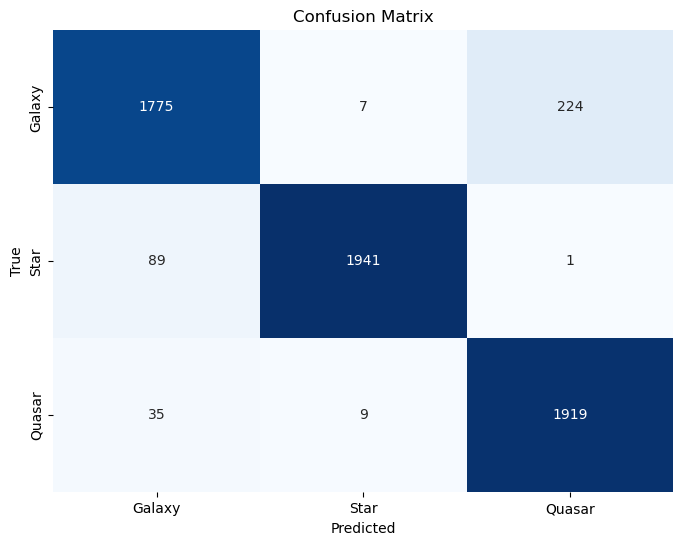

In [43]:
y_pred = clf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Galaxy', 'Star', 'Quasar'],
            yticklabels=['Galaxy', 'Star', 'Quasar'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': Continuous(1e-5, 1e10),  # Continuous range from 1e-5 to 1e10
    'gamma': Continuous(1e-15, 1e3),  # Continuous range from 1e-15 to 1e3
    'kernel': Categorical(['linear', 'rbf', 'poly'])
}

# Create the SVM classifier
svc = SVC()


# Create the genetic algorithm search object
ga_search = GASearchCV(
    estimator=svc,
    cv=cv,
    scoring='accuracy',
    population_size=5,
    generations=5,
    tournament_size=3,
    elitism=True,
    crossover_probability=0.5,
    mutation_probability=0.1,
    param_grid=param_grid,
    criteria='max',
    algorithm='eaMuPlusLambda',
    n_jobs=-1,
    verbose=True,
    keep_top_k=3 
)

# Perform the hyperparameter tuning
# ga_search.fit(X_train, y_train)

In [ ]:
# # Get the best hyperparameters and accuracy score
# best_params = ga_search.best_params_
# best_score = ga_search.best_score_

# # Train the classifier with the best hyperparameters
# best_clf = SVC(C=best_params['C'], gamma=best_params['gamma'])
# best_clf.fit(X_train, y_train)

# # Predict the labels for the test set using the best classifier
# y_pred = best_clf.predict(X_test)

# # Calculate the accuracy of the best classifier
# accuracy = accuracy_score(y_test, y_pred)

# # Print the results
# print("Best Hyperparameters:", best_params)
# print("Best Accuracy:", best_score)
# print("Test Accuracy:", accuracy)

# Random Forest

In [44]:
rfc = RandomForestClassifier(random_state=random_seed)

## Baseline
Performance of classifier using the default hyperparameter values

In [45]:
rfc.fit(X_train,y_train)

y_test_pred_rfc = rfc.predict(X_test)
y_valid_pred_rfc = rfc.predict(X_valid)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_rfc)
validation_accuracy = accuracy_score(y_valid, y_valid_pred_rfc)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.9813333333333333
Validation set Accuracy: 0.982


In [46]:

print(classification_report(y_test, y_test_pred_rfc))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2006
           1       0.99      0.96      0.98      2031
           2       0.99      1.00      0.99      1963

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



## Genetic optimisation

In [48]:
param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform',
                                                     random_state=random_seed),
              'n_estimators': Integer(100, 300,random_state=random_seed)}

# Write about why we use StratifiedKFold
# https://stackoverflow.com/questions/65318931/stratifiedkfold-vs-kfold-in-scikit-learn
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

evolved_estimator = GASearchCV(estimator=rfc,
                               cv=cv,
                               scoring='accuracy',
                               population_size=15,
                               generations=5,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.5,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=3)

In [49]:
# TAKES ABOUT 15-20 MINUTES TO RUN
evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	15    	0.917978	0.0569709  	0.969      	0.740889   
1  	17    	0.953852	0.0183794  	0.969611   	0.916222   
2  	18    	0.962396	0.0116102  	0.969611   	0.921389   
3  	18    	0.969185	0.000288081	0.969611   	0.968833   
4  	20    	0.969574	9.86882e-05	0.969778   	0.969389   
5  	17    	0.96963 	5.97204e-05	0.969778   	0.969556   


GASearchCV(crossover_probability=0.5,
           cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
           estimator=RandomForestClassifier(min_weight_fraction_leaf=0.014454547118247537,
                                            n_estimators=200, random_state=42),
           generations=5, keep_top_k=3, mutation_probability=0.1, n_jobs=-1,
           param_grid={'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x17c97b950>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x17c9791d0>},
           population_size=15, return_train_score=True, scoring='accuracy')

In [50]:
y_test_predict_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_test_predict_ga)

0.9693333333333334

In [51]:
y_valid_pred_ga = evolved_estimator.predict(X_valid)
accuracy_score(y_valid, y_valid_pred_ga)

0.9711666666666666

In [52]:
print(classification_report(y_test, y_test_predict_ga))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2006
           1       0.98      0.94      0.96      2031
           2       0.98      1.00      0.99      1963

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



In [53]:
# Top 3 set of hyperparameter value combinations
pd.DataFrame(evolved_estimator.hof)

,0,1,2
min_weight_fraction_leaf,0.014455,0.014455,0.014455
n_estimators,200.000000,200.000000,231.000000


# Gradient Boosting Classifier

## Baseline

In [54]:
gbc = GradientBoostingClassifier(random_state=random_seed)

In [55]:
# TAKES 5 MINUTES TO RUN
gbc.fit(X_train, y_train)

y_test_pred = gbc.predict(X_test)
y_valid_pred = gbc.predict(X_valid)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
validation_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.978
Validation set Accuracy: 0.9805


## Genetic Optimisation

In [56]:
gbc = GradientBoostingClassifier(random_state=random_seed)

param_grid = {
    'learning_rate': Categorical([0.0001, 0.001, 0.01, 0.1],random_state=random_seed),
    'n_estimators': Integer(50, 200, distribution='uniform',random_state=random_seed)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

evolved_estimator = GASearchCV(estimator=gbc,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=5,
                               tournament_size=2,
                               elitism=True,
                               crossover_probability=0.5,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=3)

In [57]:
# TAKES 150 MINUTES TO RUN
gbc_evolved_estimator = evolved_estimator.fit(X_train,y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.969611	0.00598713 	0.978556   	0.962556   
1  	12    	0.97095 	0.00442422 	0.977444   	0.962556   
2  	9     	0.973483	0.00441134 	0.9785     	0.968444   
3  	13    	0.9773  	0.00298248 	0.978556   	0.968444   
4  	16    	0.978544	2.22222e-05	0.978556   	0.9785     
5  	12    	0.978556	1.11022e-16	0.978556   	0.978556   


In [58]:

y_test_pred_gbc_ga = evolved_estimator.predict(X_test)
y_valid_pred_gbc_ga = evolved_estimator.predict(X_valid)

# Evaluate the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_gbc_ga)
validation_accuracy = accuracy_score(y_valid, y_valid_pred_gbc_ga)
print("Test set Accuracy:", test_accuracy)
print("Validation set Accuracy:", validation_accuracy)

Test set Accuracy: 0.9785
Validation set Accuracy: 0.9818333333333333


In [59]:
print(classification_report(y_test, y_test_pred_gbc_ga))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2006
           1       0.99      0.96      0.97      2031
           2       0.99      1.00      0.99      1963

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



In [60]:
# Top 3 set of hyperparameter value combinations
pd.DataFrame(gbc_evolved_estimator.hof)

,0,1,2
learning_rate,0.1,0.1,0.1
n_estimators,179.0,164.0,179.0
